In [ ]:
# Import packages.
from __future__ import absolute_import, division, print_function

import argparse
import os
import sys
import numpy as np
from os.path import join
import time

from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from keras import layers, models #, optimizers, regularizers activations, 
from keras import backend as K

from utils_plot import violinplot
sys.path.append('../../training/')
from resnet_model import UncerEstim
from utils import seq2onehot

In [2]:
# Compute the mean and variance of the predicted beta distribution.
class BetaLayer(layers.Layer):
    """Tranform the shape parameters into mean and variance of the beta
    distributions"""
    def __init__(self, **kwargs):
        super(BetaLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(BetaLayer, self).build(input_shape)
    
    def call(self, x):
        a, b = tf.split(tf.stack(x), 2, axis=2)  # a, b are n_models x n_samples
        a_plus_b = a + b

        # mu, sigma2 are n_models x n_samples
        mu = a / a_plus_b
        sigma2 = (a * b) / (K.square(a_plus_b) * (a_plus_b + 1))
             
        predictive_mean = K.mean(mu, axis=0)
        predictive_var = K.mean(sigma2, axis=0) + K.var(mu, axis=0)
        out = [predictive_mean, predictive_var]
        return out

In [3]:
# Choose GPU.
cuda = 7
os.environ['CUDA_VISIBLE_DEVICES'] = str(cuda)

In [4]:
# Set constants.
input_shape = np.zeros((1, 17, 4))  # input size
model_number = [1, 2]  # set of hyperparameters
epoch_number = [52, 52]  # epoch (divided by 5) chosen after early stopping
seed_ensemble = [10, 20, 30, 40, 50]  # seeds of the elements of the ensemble

In [5]:
# Set path to the test data
path_test = '../../../data'

In [6]:
# Building model.
US = UncerEstim(args=None)

# Loading the weights of all ten elements of the ensemble.
model1 = {}
model2 = {}
for ens in seed_ensemble:
    path_ens = '../weights'
    model1[ens] = models.load_model(join(path_ens, 
            'model{}_ens{}_eval{}.h5'.format(model_number[0], ens, epoch_number[0])), 
            custom_objects={'loss_function_in': US.custom_objective()})
    model2[ens] = models.load_model(join(path_ens, 
            'model{}_ens{}_eval{}.h5'.format(model_number[1], ens, epoch_number[1])), 
            custom_objects={'loss_function_in': US.custom_objective()})
                                                     
# Reshaping input layer.
for ens in seed_ensemble:
    model1[ens].layers.pop(0)
    model2[ens].layers.pop(0)
newInput = layers.Input(shape=(input_shape.shape[1], input_shape.shape[2]))

# Creating output layer.
newOutput1 = {}
newOutput2 = {}
for ens in seed_ensemble:
    newOutput1[ens] = model1[ens](newInput)
    newOutput2[ens] = model2[ens](newInput)
new_output = BetaLayer()([newOutput1[10], newOutput1[20], newOutput1[30], 
                          newOutput1[40], newOutput1[50],
                          newOutput2[10], newOutput2[20], newOutput2[30], 
                          newOutput2[40], newOutput2[50]])
                                                     
# Renaming models, to remove name ambiguity. 
for ens in seed_ensemble:
    model1[ens].name = 'model1_{}'.format(ens)
    model2[ens].name = 'model2_{}'.format(ens)
    
# Creating model.
model = models.Model(inputs=newInput, outputs=new_output)

In [7]:
# Load test data.
sequences_tst = np.load(join(path_test, 'sequences_test.npy'))
sequences_tst_onehot = seq2onehot(sequences_tst, vector_form=False)
ground_truth_targets_tst = np.load(join(path_test, 'targets_test.npy'))

# Predict mean (target) and variance (uncertainty) of the beta probality density.
output = model.predict(sequences_tst_onehot)
output = np.array(output).squeeze()

predicted_targets_tst = output[0]
# output the standard deviation instead of the variance
predicted_uncertainty_tst = np.sqrt(output[1]) 

# Evaluate coefficient of determination and mean absolute error.
r2 = r2_score(ground_truth_targets_tst, predicted_targets_tst)
mae = mean_absolute_error(ground_truth_targets_tst, predicted_targets_tst)

# Print results.
print('R2 = {}, MAE = {}'.format(r2, mae))

R2 = 0.9274205201901876, MAE = 0.03901476344455851


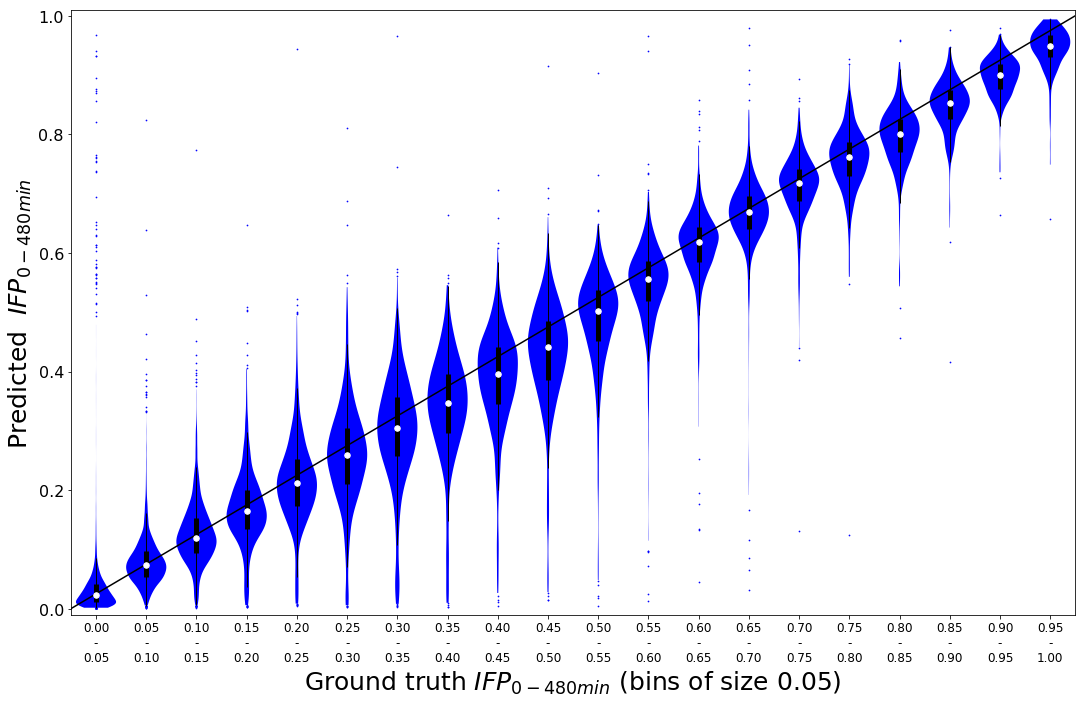

In [8]:
# Violin plot
violinplot(ground_truth_targets_tst, predicted_targets_tst)